# Project : Airbnb New User Booking
---


### Abstact :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}$$

$$nDCG_k=\frac{DCG_k}{IDCG_k}$$


- model : Light GBM

- score :  0.88461 (top 11%)

In [184]:
import numpy as np
import pandas as pd
from IPython.core.display import Image 
from scipy.stats import mode
import re
from datetime import datetime
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.metrics import classification_report

import requests
from bs4 import BeautifulSoup

import lightgbm as lgb
from lightgbm import plot_importance

import warnings

warnings.filterwarnings('ignore')

In [235]:
df_train = pd.read_csv("train_users_2.csv")
df_test = pd.read_csv("test_users.csv")
df_countries = pd.read_csv('countries.csv')
df_sessions = pd.read_csv('sessions.csv')
df_age_bkts = pd.read_csv('age_gender_bkts.csv')

In [236]:
df_all = pd.concat([df_train, df_test], axis=0)
train_id = df_train.id
test_id = df_test.id
all_id = df_all.id

In [237]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [238]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [239]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [240]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [241]:
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


In [242]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [243]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [244]:
df_countries.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [245]:
df_age_bkts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
age_bucket                 420 non-null object
country_destination        420 non-null object
gender                     420 non-null object
population_in_thousands    420 non-null float64
year                       420 non-null float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


In [246]:
df_age_bkts.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


# country destination

In [247]:
df_train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

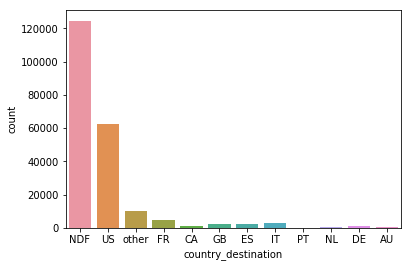

In [248]:
ax = sns.countplot(x=df_train.country_destination , data=df_train)
plt.show()

In [249]:
round(df_train["country_destination"].value_counts() / len(df_train) * 100, 2)

NDF      58.35
US       29.22
other     4.73
FR        2.35
IT        1.33
GB        1.09
ES        1.05
CA        0.67
DE        0.50
NL        0.36
AU        0.25
PT        0.10
Name: country_destination, dtype: float64

# feature engineering

# date time convert

In [250]:
#date account create
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"], format = "%Y-%m-%d")

#timestamp first active
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"], format="%Y%m%d%H%M%S")

In [251]:
df_all['create_year'] = df_all["date_account_created"].apply(lambda x : x.year)
df_all['create_month'] = df_all["date_account_created"].apply(lambda x : x.month)
df_all['create_day'] = df_all["date_account_created"].apply(lambda x : x.day)

df_all['active_year'] = df_all["timestamp_first_active"].apply(lambda x : x.year)
df_all['active_month'] = df_all["timestamp_first_active"].apply(lambda x : x.month)
df_all['active_day'] = df_all["timestamp_first_active"].apply(lambda x : x.day)

In [252]:
df_all.shape

(275547, 22)

In [253]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,signup_app,signup_flow,signup_method,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,Web,0,facebook,2009-03-19 04:32:55,2010,6,28,2009,3,19
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,Web,0,facebook,2009-05-23 17:48:09,2011,5,25,2009,5,23
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,Web,3,basic,2009-06-09 23:12:47,2010,9,28,2009,6,9
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,Web,0,facebook,2009-10-31 06:01:29,2011,12,5,2009,10,31
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,Web,0,basic,2009-12-08 06:11:05,2010,9,14,2009,12,8


# lagging time

In [254]:
lagging = df_all["timestamp_first_active"] - df_all["date_account_created"]

In [255]:
#lagging time days, log seconds
df_all["lag_days"] = lagging.apply(lambda x : -1 * x.days)
df_all["lag_seconds"] = np.log(lagging.apply(lambda x : x.seconds))

In [259]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,2009-03-19 04:32:55,2010,6,28,2009,3,19,466,9.703511,0
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2009-05-23 17:48:09,2011,5,25,2009,5,23,732,11.068028,0
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,2009-06-09 23:12:47,2010,9,28,2009,6,9,476,11.333404,0
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,2009-10-31 06:01:29,2011,12,5,2009,10,31,765,9.984560,1
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,2009-12-08 06:11:05,2010,9,14,2009,12,8,280,10.010771,0


# holiday

In [256]:
def get_holidays(year):
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"                                &country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")

    trs = dom.select("table.cht.lpad tr")

    df = pd.DataFrame(columns=["date", "holiday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1}
    return df

holiday_ls = []
for year in range(2009, 2015):
    df = get_holidays(year)
    holiday_ls.append(df)
    holiday_df = pd.concat(holiday_ls)

In [257]:
select_date = list(holiday_df["date"].astype("str"))
holiday = df_all.timestamp_first_active.apply(lambda x : str(x.date())).isin(select_date)

df_all["holiday"] = holiday
df_all['holiday'] = 1 * (df_all.holiday == True)

In [258]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,timestamp_first_active,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,2009-03-19 04:32:55,2010,6,28,2009,3,19,466,9.703511,0
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2009-05-23 17:48:09,2011,5,25,2009,5,23,732,11.068028,0
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,2009-06-09 23:12:47,2010,9,28,2009,6,9,476,11.333404,0
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,2009-10-31 06:01:29,2011,12,5,2009,10,31,765,9.984560,1
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,2009-12-08 06:11:05,2010,9,14,2009,12,8,280,10.010771,0


# weekend

In [261]:
weekday = df_all.filter(items=['id','timestamp_first_active'])
weekday = pd.to_datetime(weekday["timestamp_first_active"], format="%Y-%m-%d")
weekday = weekday.dt.dayofweek

df_all["weekend"] = weekday.apply(lambda x : 1 if x>=5 else 0)

In [262]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,...,create_year,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,...,2010,6,28,2009,3,19,466,9.703511,0,0
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,...,2011,5,25,2009,5,23,732,11.068028,0,1
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,...,2010,9,28,2009,6,9,476,11.333404,0,0
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,...,2011,12,5,2009,10,31,765,9.984560,1,1
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,...,2010,9,14,2009,12,8,280,10.010771,0,0


In [268]:
df_all = df_all.drop("date_account_created" , axis=1)
df_all = df_all.drop("timestamp_first_active" , axis=1)

# faithless sign-in

In [269]:
checklist = (df_all['age'] < 120) & (df_all['gender'] != '-unknown-')

df_all['faithless_sign'] = checklist.apply(lambda x : 0 if x == True else 1)

In [270]:
df_all.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,...,create_month,create_day,active_year,active_month,active_day,lag_days,lag_seconds,holiday,weekend,faithless_sign
0,direct,direct,NaN,NDF,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,...,6,28,2009,3,19,466,9.703511,0,0,1
1,seo,google,38.0,NDF,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,...,5,25,2009,5,23,732,11.068028,0,1,0
2,direct,direct,56.0,US,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,...,9,28,2009,6,9,476,11.333404,0,0,0
3,direct,direct,42.0,other,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,...,12,5,2009,10,31,765,9.984560,1,1,0
4,direct,direct,41.0,US,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,...,9,14,2009,12,8,280,10.010771,0,0,1


# null data

In [271]:
df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [272]:
df_test.isnull().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

In [273]:
#null data of country_destination is due to concanate train / test data.
df_all.isnull().sum()

affiliate_channel               0
affiliate_provider              0
age                        116866
country_destination         62096
date_first_booking         186639
first_affiliate_tracked      6085
first_browser                   0
first_device_type               0
gender                          0
id                              0
language                        0
signup_app                      0
signup_flow                     0
signup_method                   0
create_year                     0
create_month                    0
create_day                      0
active_year                     0
active_month                    0
active_day                      0
lag_days                        0
lag_seconds                     0
holiday                         0
weekend                         0
faithless_sign                  0
dtype: int64

In [274]:
print('Train data missing data ratio')
print('date_frist_booking      :',round(df_train.date_first_booking.isnull().sum() / len(df_train) * 100, 2), "%")
print('age                     :',round(df_train.age.isnull().sum() / len(df_train) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_train.first_affiliate_tracked.isnull().sum() / len(df_train) * 100, 2), "%")

Train data missing data ratio
date_frist_booking      : 58.35 %
age                     : 41.22 %
first_affiliate_tracked : 2.84 %


In [275]:
print('Test data missing data ratio')
print('date_frist_booking      :',round(df_test.date_first_booking.isnull().sum() / len(df_test) * 100, 2), "%")
print('age                     :',round(df_test.age.isnull().sum() / len(df_test) * 100, 2), "%")
print('first_affiliate_tracked :',round(df_test.first_affiliate_tracked.isnull().sum() / len(df_test) * 100, 2), "%")

Test data missing data ratio
date_frist_booking      : 100.0 %
age                     : 46.5 %
first_affiliate_tracked : 0.03 %


# drop data_first_booking data

In [276]:
df_all = df_all.drop("date_first_booking", axis=1)

# fill first_affiliate_tracked data by mode

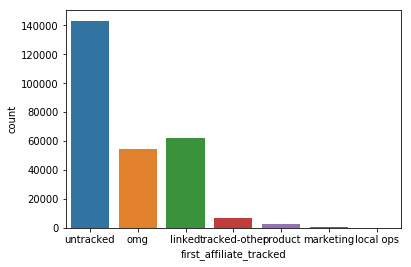

In [277]:
sns.countplot(df_all["first_affiliate_tracked"])
plt.show()

In [278]:
df_all.first_affiliate_tracked.mode()

0    untracked
dtype: object

In [279]:
df_all["first_affiliate_tracked"] = df_all["first_affiliate_tracked"].replace(np.nan, "untracked")

# age data

In [280]:
#more than 200 years old data
#keep this data for faithless-signin
#training data only
len(df_train[df_train['age']>200])

779

In [282]:
df_train[df_train['age']>200].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


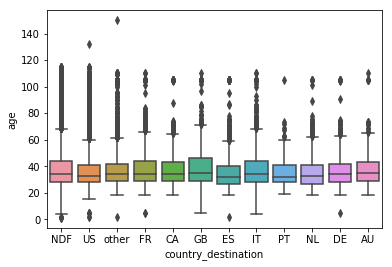

In [283]:
#on each destinations, it has various age distribution. 
#It would be better filling the null age data than dropping the age data. 
age_temp = df_train.copy()
age_temp[ age_temp['age'] > 200 ] = np.nan
sns.boxplot(x=age_temp.country_destination, y=age_temp.age, data=age_temp)
plt.show()

# one-hot encoding before fill age data

In [287]:
df_age = df_all.filter(items = ['age', 'country_destination','id', 'gender'])
df_dummy = df_all.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                       'language', 'signup_app', 'signup_flow', 'signup_method', 
                                       'create_year', 'create_month', 'create_day', 
                                       'active_year', 'active_month', 'active_day', 'lag_days', 'lag_seconds', 
                                       'holiday', 'weekend'])
    
df_dummy = pd.get_dummies(df_dummy)
df_all = pd.concat([df_age, df_dummy], axis=1)

In [288]:
df_all.shape

(275547, 146)

In [289]:
df_all.head()

,age,country_destination,id,gender,signup_flow,create_year,create_month,create_day,active_year,active_month,...,language_tr,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo
0,NaN,NDF,gxn3p5htnn,-unknown-,0,2010,6,28,2009,3,...,0,0,0,0,1,0,0,1,0,0
1,38.0,NDF,820tgsjxq7,MALE,0,2011,5,25,2009,5,...,0,0,0,0,1,0,0,1,0,0
2,56.0,US,4ft3gnwmtx,FEMALE,3,2010,9,28,2009,6,...,0,0,0,0,1,0,1,0,0,0
3,42.0,other,bjjt8pjhuk,FEMALE,0,2011,12,5,2009,10,...,0,0,0,0,1,0,0,1,0,0
4,41.0,US,87mebub9p4,-unknown-,0,2010,9,14,2009,12,...,0,0,0,0,1,0,1,0,0,0


# fill age data

In [290]:
#divide train / test by null age data
age_train = df_all[df_all["age"].notnull()].reset_index(drop=True)
age_test = df_all[df_all["age"].isnull()].reset_index(drop=True)

In [291]:
#divide 5 cluster age data
bins = [0, 15, 25, 35, 60, 2015]
labels = ["underage", "tweenty", "thirty", "mid_old", "old"]
cats = pd.cut(age_train['age'], bins, labels=labels)
cats = pd.DataFrame(cats)

In [292]:
age_train_id = age_train.id
age_test_id = age_test.id

age_train = age_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
age_test = age_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)

In [293]:
X = age_train
y = cats

age_train.shape, y.shape, age_test.shape

((158681, 142), (158681, 1), (116866, 142))

In [294]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
model_age = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=-1, reg_alpha=0.5, reg_lambda=0.5).fit(X_train, y_train)
pred_age = model_age.predict(X_test)

print(classification_report(y_test, pred_age))

             precision    recall  f1-score   support

    mid_old       0.48      0.38      0.42     11150
        old       0.75      0.00      0.00      2044
     thirty       0.49      0.78      0.60     14036
    tweenty       0.45      0.04      0.07      4490
   underage       0.25      0.06      0.10        17

avg / total       0.50      0.48      0.42     31737



In [299]:
pred_age = model_age.predict(age_test)
pred_age = pd.DataFrame(pred_age)
pred_age = pd.concat([pred_age, age_test_id], axis=0)
pred_age.head()

,0
0,thirty
1,thirty
2,thirty
3,mid_old
4,thirty


In [ ]:
df_all = pd.merge(df_all, pred_age, on="id", how="left")
last_train_data = pd.merge(last_train_data, last_gen_add_dum, on="id", how="left")


# filling gender data

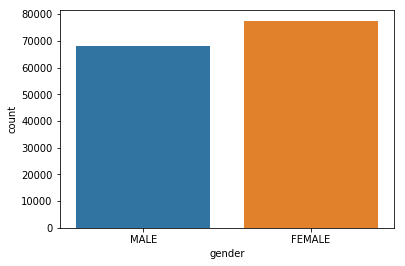

In [327]:
sns.countplot(df_all["gender"])
plt.show()

In [319]:
df_all["gender"] = df_all["gender"].replace(['-unknown-', 'OTHER'], np.nan)

gender_train = df_all[df_all["gender"].notnull()].reset_index()
gender_test = df_all[df_all["gender"].isnull()].reset_index()

In [320]:
y = gender_train.gender

gender_train = gender_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
gender_test = gender_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)

In [321]:
X = gender_train

gender_train.shape, y.shape, gender_test.shape

((145733, 141), (145733,), (129814, 141))

In [322]:
#model recall rate is so low, but it gives better cross validation score for final prediction model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
model_age = lgb.LGBMClassifier(n_estimators=500, n_jobs=-1, reg_alpha=1).fit(X_train, y_train)
pred_age = model_age.predict(X_test)

print(classification_report(y_test, pred_age))

             precision    recall  f1-score   support

     FEMALE       0.57      0.68      0.62     15550
       MALE       0.53      0.43      0.47     13597

avg / total       0.56      0.56      0.55     29147



In [323]:
pred_gender = model_age.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender)

##### 1-2. Age

In [36]:
labels = ["0:0-27", "1:27-31", "2:31-36", "3:36-46", "4:46-"]

In [37]:
df_train["age_cut"] = pd.qcut(df_train[df_train["age"] <= 120]['age'], 5, labels = labels)

In [38]:
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)

In [39]:
df_age_pivot

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
age_cut,,,,,,,,,,,,
0:0-27,65,174,186,448,695,351,437,12255,150,36,9808,1471
1:27-31,97,224,160,312,681,296,340,9995,102,35,10250,1550
2:31-36,78,219,159,373,738,336,429,10630,131,35,10561,1665
3:36-46,111,243,176,298,810,357,392,12083,111,23,9715,1521
4:46-,84,211,163,266,770,424,425,11561,103,28,8009,1324


In [40]:
for c in df_age_pivot.index:
    df_age_pivot.loc[c] = (df_age_pivot.loc[c] / (df_train["age_cut"] == c).sum() * 100)

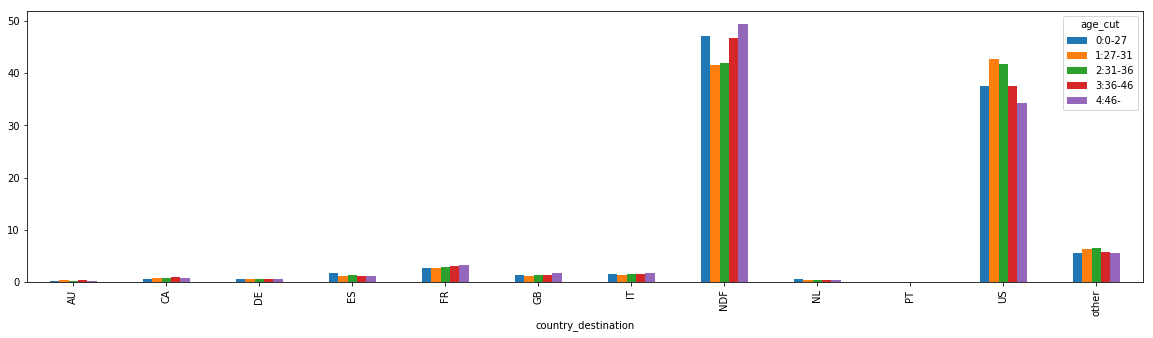

In [41]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))

(0, 4)

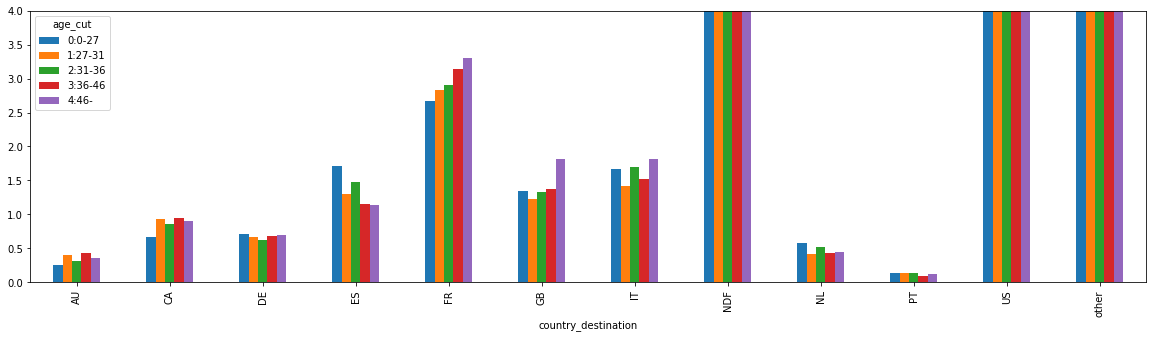

In [42]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))
plt.ylim([0,4])

- NDF : 27-36세는 NDF가 아닐 확률이 높다.
- US  : 27-36세는 US로 여행할 확률이 높다.
- FR  : 나이가 늘어 날수록 여행갈 비율이 높다.
- other : 27-36세는 other에 여행할 확률이 약간 높다.
- GB  : 46-세는 GB에 여행갈 확률이 높다
- ES  : 0-27세는 ES에 여행갈 확률이 높다.

##### 2-2. Session info

- **가정) 사이트를 자주 들어간 사람일수록 여행을 예약할 확률이 높다**
  - 각 `user_id`별 session count 갯수가 많을 수록, 사이트를 자주 들어 왔다고 가정
- **추가 사항 : secs_elapse_mean, secs_elapse_mode, secs_elapse_sum, device_type_mode**

##### action, action_type, action_detail count

In [377]:
## make action count
tmp = df_sessions.groupby(["user_id", "action_type"])["secs_elapsed"].count().unstack().fillna(0)
df_session_type = pd.DataFrame(tmp)
df_session_type.rename(columns = lambda x : "type_" + x, inplace = True)

In [378]:
## make action_type count
tmp = df_sessions.groupby(["user_id", "action"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action = pd.DataFrame(tmp)
df_session_action.rename(columns = lambda x : "action_" + x, inplace = True)

In [379]:
## make action_detail count
tmp = df_sessions.groupby(["user_id", "action_detail"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action_detail = pd.DataFrame(tmp)
df_session_action_detail.rename(columns = lambda x : "detail_" + x, inplace = True)

In [380]:
df_session_info = df_session_type.merge(df_session_action, how = "left", left_index = True, right_index = True)
df_session_info = df_session_info.merge(df_session_action_detail, how = "left", left_index = True, right_index = True)

In [381]:
## drop unknown value
df_session_info.drop(["type_-unknown-", "detail_-unknown-"], axis = 1, inplace = True)

In [ ]:
## impute the missing value using median
from sklearn.preprocessing import Imputer

df_train = df_train_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)
df_test = df_test_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_train[df_session_info.columns.tolist()] = imp.fit_transform(df_train[df_session_info.columns.tolist()])
df_test[df_session_info.columns.tolist()] = imp.fit_transform(df_test[df_session_info.columns.tolist()])

##### 2-4. Lag-time

- **가정) 활동 빈도가 적을 수록 여행을 예약할 확률이 낮다**
  - 처음으로 활동한 날짜 - 처음 계정을 생성한 날짜

In [ ]:
df_train["date_account_created"] = pd.to_datetime(df_train["date_account_created"], format = "%Y-%m-%d")
df_train["timestamp_first_active"] = pd.to_datetime(df_train["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')
df_test["date_account_created"] = pd.to_datetime(df_test["date_account_created"], format = "%Y-%m-%d")
df_test["timestamp_first_active"] = pd.to_datetime(df_test["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')

In [ ]:
s_train_lag = df_train["timestamp_first_active"] - df_train["date_account_created"]
s_test_lag = df_test["timestamp_first_active"] - df_test["date_account_created"]

In [ ]:
df_train["lag_days"] = s_train_lag.apply(lambda x : -1 * x.days)
df_test["lag_days"] = s_test_lag.apply(lambda x : -1 * x.days)
df_train["lag_seconds"] = s_train_lag.apply(lambda x : x.seconds)
df_test["lag_seconds"] = s_test_lag.apply(lambda x : x.seconds)

#### (3) Featrues selection

##### 3-1. Use importance feature

### 4. Modeling

#### (1) Selection Model

#### (2) Parameter tuning

### 5. Analysis the result

In [ ]:
! kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f submission.csv -m "Message"

---

---

---

### DecisionTree image

In [ ]:
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(X_test_75.drop(['id', 'country_destination'],axis=1), y_label)

In [ ]:
submit_kaggle(X_test_3, y_test_3, tree1, './submission/submit_xg.csv', "id", "country_destination")

In [ ]:
def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=X_test_75.columns.drop(['id', 'country_destination']))
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [ ]:
draw_decision_tree(tree1)